In [1]:
# Import other modules not related to PySpark
import os 
import sys   
import pandas as pd
from pandas import DataFrame 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick  
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline


In [70]:
df = pd.read_csv('merged4_clean_1.csv'  ) 
df['Date de creation'] = pd.to_datetime(df['Date de creation'])
df.set_index('Date de creation', inplace=True)
daily_tickets = df.resample('D').size()
daily_tickets = daily_tickets.rename('tickets_count').reset_index()
daily_tickets.set_index('Date de creation', inplace=True)
daily_tickets 

,tickets_count
Date de creation,
2016-05-19,140
2016-05-20,108
2016-05-21,2
2016-05-22,5
2016-05-23,135
...,...
2024-02-12,263
2024-02-13,272
2024-02-14,240


In [71]:
split_date = '2022-01-01'

# Split the data
train = daily_tickets[daily_tickets.index < split_date]
test = daily_tickets[daily_tickets.index >= split_date]


<Figure size 864x432 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Tickets')

Text(0.5, 1.0, 'Daily Number of Created Tickets')

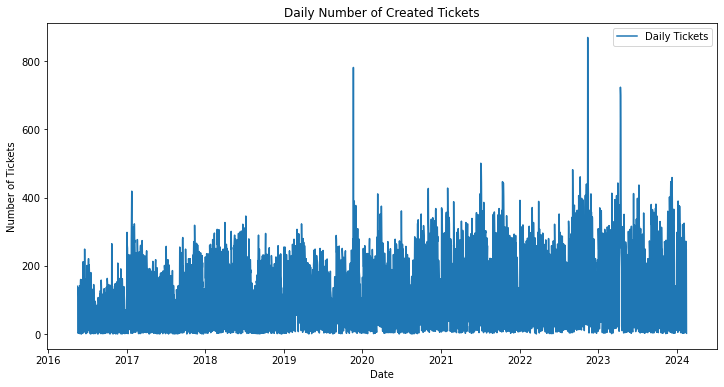

In [31]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(daily_tickets.index, daily_tickets['tickets_count'], label='Daily Tickets')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.title('Daily Number of Created Tickets')
plt.legend()
plt.show()


In [77]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """ 
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X



C:\Users\ahmed\AppData\Local\Temp\ipykernel_18244\4271627047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
C:\Users\ahmed\AppData\Local\Temp\ipykernel_18244\4271627047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
C:\Users\ahmed\AppData\Local\Temp\ipykernel_18244\4271627047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

XGBoost RMSE: 79.49625027365391
XGBoost R²: 0.644050182068729


C:\Users\ahmed\AppData\Local\Temp\ipykernel_18244\4271627047.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


<Figure size 1008x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Tickets')

Text(0.5, 1.0, 'Actual vs Predicted Number of Created Tickets')

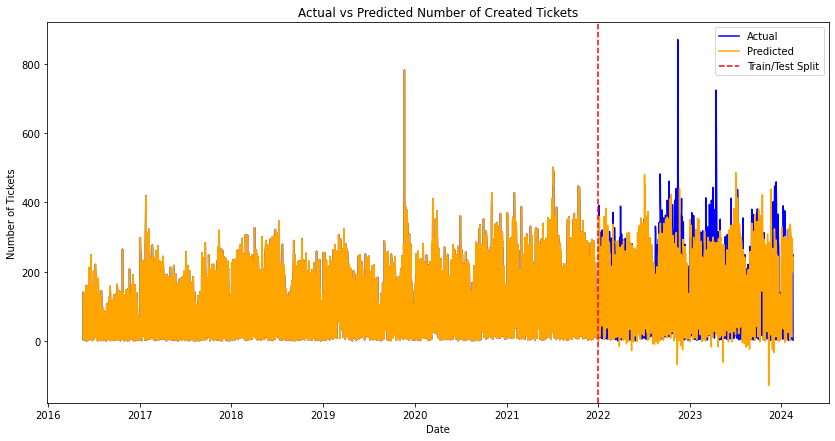

In [85]:
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


X_train, y_train = create_features(train, label='tickets_count');

# Create features and labels for the test set
X_test, y_test = create_features(test, label='tickets_count');

# Train the XGBoost model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_reg.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = xgb_reg.predict(X_test)

# Make predictions for the entire dataset
X_all, y_all = create_features(daily_tickets, label='tickets_count')
y_pred_all = xgb_reg.predict(X_all)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f'XGBoost RMSE: {rmse}')
print(f'XGBoost R²: {r2}')

# Plot actual vs predicted values for the test set only
plt.figure(figsize=(14, 7))
plt.plot(daily_tickets.index, y_all, label='Actual', color='blue')
plt.plot(daily_tickets.index, y_pred_all, label='Predicted', color='orange')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train/Test Split')
plt.xlabel('Date') 
plt.ylabel('Number of Tickets')
plt.title('Actual vs Predicted Number of Created Tickets')
plt.legend()
plt.show()



In [113]:
class Subject:
    def __init__(self, score, coefficient):
        self.score = score
        self.coefficient = coefficient

Subjects = []



python = Subject(13.5, 1.5)
gestion_ent = Subject(6, 1) 
eng = Subject(4.3, 1)  
dba = Subject(12, 1.5)
graph = Subject(10.45, 1)
java = Subject(15.05, 2)
cpp = Subject(10.2, 1.5)
xml = Subject(12.9, 1.5)
proj = Subject(16, 1)
eng2 = Subject(14.7, 1)
droit = Subject(5.1, 1)
web = Subject(17.65, 1.5)
index = Subject(10.3, 1) 
istqb = Subject(13.42, 1)




#### high prior 
##proba = Subject(2.55, 2)############## 7 days ###### very high  ((calcul ))

proba = Subject(8, 2)############## 7 days ###### very high  ((calcul ))
ai = Subject(7.3, 2) #################### 4 days #### high ((5edma / 7fitha ))
##iot = Subject(5.4, 1.5) ######################### 10 days  #### high ((7fitha ))
iot = Subject(7, 1.5) ######################### 10 days  #### high ((7fitha ))
##comp = Subject(4.6, 1.5) ############## 4 days ### very high 
comp = Subject(8, 1.5) ############## 4 days ### very high 


#### medium prior 

concep = Subject(8.2, 1.5)############### 9 days 
res = Subject(8, 1) ##################### 11 days 


#### low prior 

tla = Subject(5.05, 1) ############## 8 days 
dba2 = Subject(7.65, 1)  #########  3 days 
entr = Subject(6.6, 1) ############# 2 days 





# Adding subjects to the list
Subjects.extend([python, iot, gestion_ent, eng, dba, res, graph, tla, proba, concep, java, 
                 cpp, xml, proj, eng2, droit, ai, web, index, istqb, comp, dba2, entr])

# Calculating the weighted average
total_sum = sum(subject.score * subject.coefficient for subject in Subjects)
total_coeff = sum(subject.coefficient for subject in Subjects)
average = total_sum / total_coeff if total_coeff != 0 else 0

print("The weighted average is:", average)



The weighted average is: 10.0815


In [ ]:
python = 13.5 * 1.5 
iot = 5.4 * 1.5 
gestion_ent = 6 * 1 
eng = 4.3 * 1 
dba = 12 * 1.5 
res = 3.1 * 1 
graph = 10.45 * 1
tla = 5.05 * 1 
proba = 2.55 * 2 
concep = 8.2 * 1.5 
java = 15 * 2 

(python + iot + gestion_ent + eng + dba + res + graph + tla + proba + concep + java ) 



In [62]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 6319.653807571421
R-squared: 0.644050182068729


In [48]:
X_test['Pred'] = y_pred
X_test  

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Pred
Date de creation,,,,,,,,,
2019-03-10,0,6,1,3,2019,69,10,10,8.693846
2020-04-01,0,2,2,4,2020,92,1,14,229.890396
2022-07-05,0,1,3,7,2022,186,5,27,302.759644
2023-12-20,0,2,4,12,2023,354,20,51,266.582397
2016-12-01,0,3,4,12,2016,336,1,48,106.170425
...,...,...,...,...,...,...,...,...,...
2022-07-29,0,4,3,7,2022,210,29,30,181.217850
2016-10-29,0,5,4,10,2016,303,29,43,13.893286
2021-07-12,0,0,3,7,2021,193,12,28,335.914490


In [49]:
X_pred = X_test[['Pred']]
X_pred

,Pred
Date de creation,
2019-03-10,8.693846
2020-04-01,229.890396
2022-07-05,302.759644
2023-12-20,266.582397
2016-12-01,106.170425
...,...
2022-07-29,181.217850
2016-10-29,13.893286
2021-07-12,335.914490


In [52]:
df_all = pd.concat([daily_tickets, X_pred], sort=False)


In [53]:
df_all  

,tickets_count,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Pred
Date de creation,,,,,,,,,,,
2016-05-19,140.0,2016-05-19,0.0,3.0,2.0,5.0,2016.0,140.0,19.0,20.0,NaN
2016-05-20,108.0,2016-05-20,0.0,4.0,2.0,5.0,2016.0,141.0,20.0,20.0,NaN
2016-05-21,2.0,2016-05-21,0.0,5.0,2.0,5.0,2016.0,142.0,21.0,20.0,NaN
2016-05-22,5.0,2016-05-22,0.0,6.0,2.0,5.0,2016.0,143.0,22.0,20.0,NaN
2016-05-23,135.0,2016-05-23,0.0,0.0,2.0,5.0,2016.0,144.0,23.0,21.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-29,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.217850
2016-10-29,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.893286
2021-07-12,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335.914490


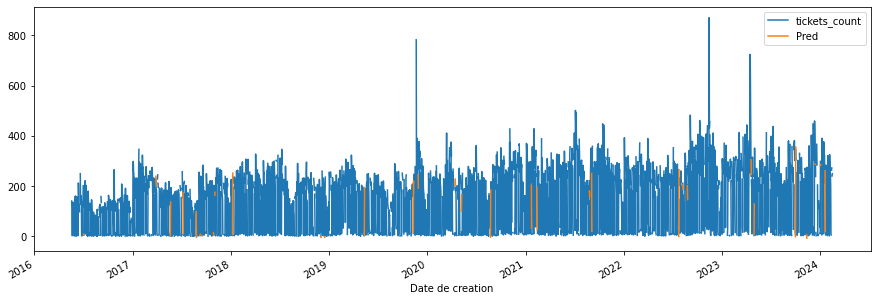

In [54]:
_ = df_all[['tickets_count','Pred']].plot(figsize=(15, 5))


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

train_size = int(len(daily_tickets) * 0.8)
train, test = daily_tickets[:train_size], daily_tickets[train_size:]

# Fit the SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit(disp=False)

# Make predictions
sarima_forecast = sarima_model.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.title('SARIMA Forecast of Daily Created Tickets')
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f'SARIMA RMSE: {rmse}')

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(daily_tickets['Date de creation'], daily_tickets['tickets_count'], label='Daily Tickets')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.title('Daily Number of Created Tickets')
plt.legend()
plt.show()


,Date de creation
0,2017-11-07 15:08:00
1,2018-06-04 20:05:00
2,2018-10-04 08:28:00
3,2019-05-03 13:28:00
4,2020-01-24 09:50:00
...,...
444545,2022-05-12 14:54:00
444546,2022-12-07 15:44:00
444547,2023-10-13 15:35:00
444548,2024-01-04 06:04:00
